In [8]:

import torch
import numpy as np
import csv
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
import itertools


<br>
There are several ways to approach this problem in unsupervised fashion<br>
1. Autoencoders can be used in an unsupervised fashion<br>
2. K means clustering is also possible but because of class imbalance, it will bias the majority samples<br>
3. One more approach is to treat this problem as (AD) Anamoly detection problem. Since the goal is to detect a signal event from a large background events. <br>
This problem is similar to fradulent transation detection or object detection from a large set of background pixels or defect detection in images using machine vision, medical diagnosis and law enforcement.<br>
We have used Anamoly approach to solve this problem. After analyzing features we found it rarely happens. the signal is being formed.<br>
There are several AD models like<br>
1. Isolation Forest<br>
2. Local Outlier Factor<br>
3. Robust Covariance<br>
4. One-Class SVM<br>
5. One-Class SVM (SGD)<br>
We used 1. Isolation Forest <br>


In [9]:
#First I look for Null values and rep;ace them with zero
def normalize(dataset):
    dataset = dataset.fillna(0)  #Replace Nans by 0 
    X = dataset.iloc[:, :14]
    X_norm = (X - X.min())/(X.max() - X.min() + 1e-8)  #Min Max Normalization, 1e-8 to avoid numerical instability like div by 0
    return X_norm, dataset

 

In [10]:
def loaddata(src):
    """Loading Data"""
    print("Loading data", src)
    src = src
    items = os.listdir(src)
    print(items)
    dataset = pd.read_csv(os.path.join(src, items[0]))   #Reading new_physics_signal.csv data file
    X_norm, dataset = normalize(dataset)   #Normalizing Data
    unsupervised_model(dataset)
    

In [12]:
"""Plotting Confusion Matrix"""
def plot_confusion_matrix(cm, classes,title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [13]:

"""Analysis of Feature Importance and Model fitting"""
def unsupervised_model(dataset): 
    #Plotting Class Distribution
    #Let us first plot the signal event vs background events using bar graph
    #in order to analyze the ratio of signal events in the dataset which is approx = len(signal)/len(background events)
    #In additon, we seprate the classes
    events = pd.value_counts(dataset['Class'], sort = True)
    events.plot(kind = 'bar')
    plt.title("Event Distribution")
    plt.xticks(range(2), ["Bg", "Signal"])
    plt.xlabel("Event Type")
    plt.ylabel("Freq")
    signal = dataset[dataset['Class'] == 1]
    bg = dataset[dataset['Class'] == 0]
    print(bg.shape, signal.shape)
    plt.show()

    ##Analysing the importance of Features P3 and P14 in Signal and Bacckground events, if there is any deviation        
    fig, (axis1, axis2) = plt.subplots(2, 1, sharex=True)
    fig.suptitle('P3 Feature vs P14 Feature')
    axis1.scatter(signal.p3, signal.p14)
    axis1.set_title('Signal')
    axis2.scatter(bg.p3, bg.p14)
    axis2.set_title('Bg Event')
    plt.xlabel('P3 Feature')
    plt.ylabel('P14 Feature')
    plt.xlim((0, 23000))
    plt.show()
    #From above graph, We observe that the p3 and p14 features didn't show any diffrence between signal and background events
    
    #Analysing the importance of Feature 14 in Signal and Bacckground events, if there is any deviation
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    f.suptitle('Last Feature Value')
    bins = 15
    ax1.hist(signal.p14, bins = bins)
    ax1.set_title('Signal')
    ax2.hist(bg.p14, bins = bins)
    ax2.set_title('Bg')
    plt.xlabel('P 14')
    plt.ylabel('Value of P14 Feature')
    plt.xlim((0, 20000))
    plt.yscale('log')
    plt.show()
    dataset.hist(figsize=(15, 15), bins = 128)
    plt.show()
    #From this plot, we observe most of signal events have smaller value of feature p14. 
    #Preparaing Dataset
    #We have only 0.17\% signal events from the dataset.
    #This implies random guess by any model should produce 0.17\% accuracy for signal detection
    dataset.sample(frac=1)  #Shuffle
    cols = dataset.columns.tolist()  #Extracting Labels
    trgt = cols[-1]
    cols = cols[:-1]
    Xtr =  dataset.iloc[:, :-1]
    ytr =  dataset.iloc[:, -1]
    Xt =  dataset.iloc[280000:, :-1]
    yt =  dataset.iloc[280000:, -1]
    print(Xtr.shape, ytr.shape, Xt.shape, yt.shape)
    #Model LocalOutlierFactor
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.ensemble import IsolationForest

    #Local Outlier for Signal from Large Background events 
    snb = 492/284315    #Signal to Background Ratio
    #model = LocalOutlierFactor(contamination=snb)
    model = IsolationForest(random_state=0).fit(Xtr)
    """We are using Labels only for evaluation purposes here"""
    y_train_pred = model.fit_predict(Xtr)
    y_train_pred[y_train_pred == 1] = 0
    y_train_pred[y_train_pred == -1] = 1   #Replacing -1 by 1 and 1 by 0 to make it consistent with our class labels
    y_test_pred = model.fit_predict(Xt)
    y_test_pred[y_test_pred == 1] = 0
    y_test_pred[y_test_pred == -1] = 1
    #Evaluation Metrics
    from sklearn.metrics import confusion_matrix
    classes = np.array(['0','1'])
    cm_train = confusion_matrix(ytr, y_train_pred)
    plot_confusion_matrix(cm_train,["Bgnd", "Signal"])
    """"Anayzing the confusion matrix, we can see 201/492 signal can be detected which is apprximately 40\% accuracy"""


Loading data /home/mir/git_repo/particle_accelerator_LHC/ML-tech-assignment-1-dataset/
['new_physics_signal.csv']
(284315, 15) (492, 15)


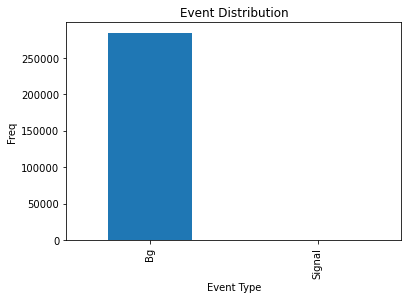

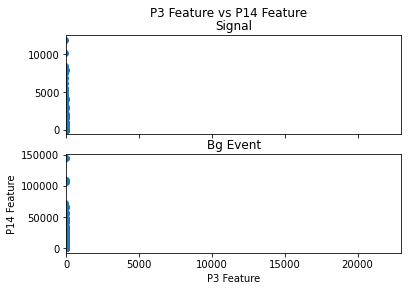

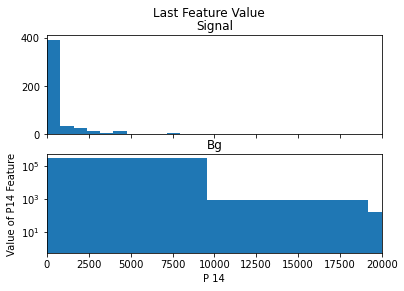

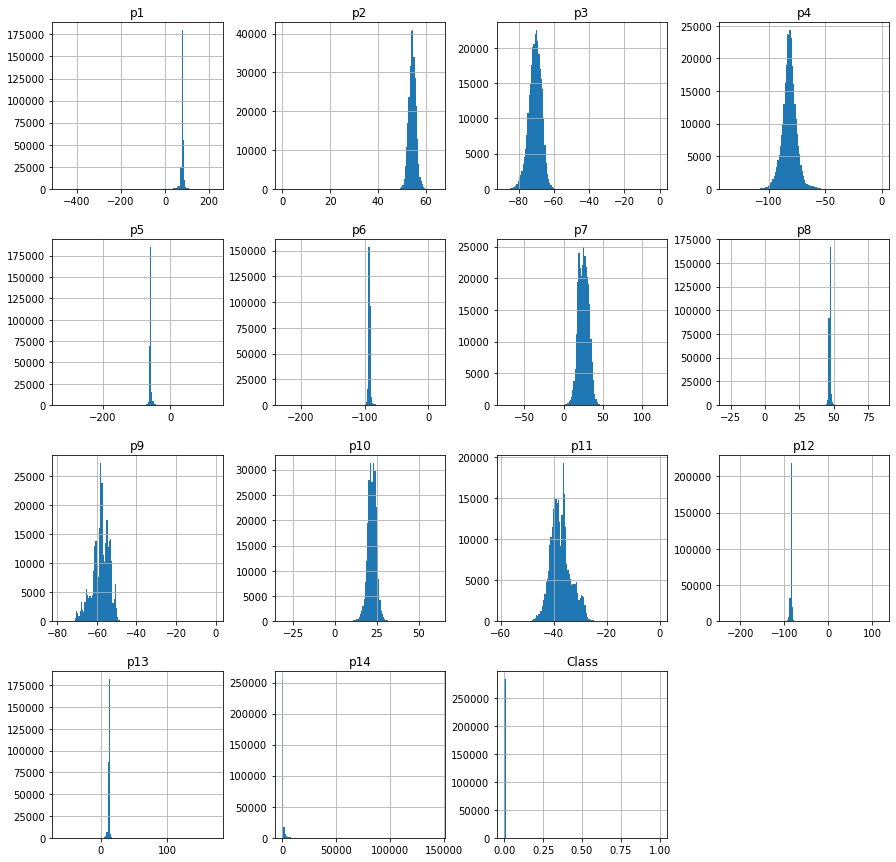

(284807, 14) (284807,) (4807, 14) (4807,)


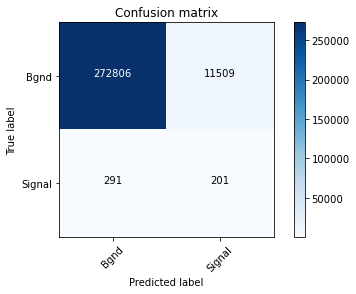

In [14]:

src = os.getcwd() + "/ML-tech-assignment-1-dataset/"
loaddata(src)